In [1]:
# Goal: code up the finite Gaussian network and prove claim below
# Claim : FGNs are indeed trainable

In [2]:
from __future__ import print_function

In [3]:
import matplotlib as mpl
# set this 'backend' when using jupyter; do this before importing pyplot
mpl.use('nbagg')
import matplotlib.pyplot as plt

In [4]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms

import numpy as np
from scipy import stats

# graph viz tool
# import sys
# sys.path.append('/home/felix/Research/Adversarial Research/FGN---Research')
import torch_helper_lib as th

/usr/local/lib/python2.7/dist-packages/requests/__init__.py:83: RequestsDependencyWarning: Old version of cryptography ([1, 2, 3]) may cause slowdown.
  warnings.warn(warning, RequestsDependencyWarning)


In [5]:
# Define what device we are using
print("CUDA Available: ",torch.cuda.is_available())
torch.manual_seed(12213)
use_cuda = False
device = torch.device("cuda" if (use_cuda and torch.cuda.is_available()) else "cpu")

CUDA Available:  True


In [6]:
# MNIST dataset and dataloader declaration
test_loader = torch.utils.data.DataLoader(
    datasets.MNIST('../MNIST-dataset', train=False, download=True, 
                   transform=transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.1307,), (0.3081,))
            ])), 
        batch_size=1, shuffle=False)

train_loader = torch.utils.data.DataLoader(
    datasets.MNIST('../MNIST-dataset', train=True, download=True, 
                   transform=transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.1307,), (0.3081,))
            ])), 
        batch_size=1, shuffle=True)

dev_loader = torch.utils.data.DataLoader(
    datasets.MNIST('../MNIST-dataset', train=True, download=True, 
                   transform=transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.1307,), (0.3081,))
            ])), 
        batch_size=1, shuffle=False, sampler=torch.utils.data.sampler.SubsetRandomSampler(range(1000)))

Shape: torch.Size([60000, 28, 28])
type: <type 'numpy.ndarray'>
Label: 0
type: <class 'torch.Tensor'>


<IPython.core.display.Javascript object>


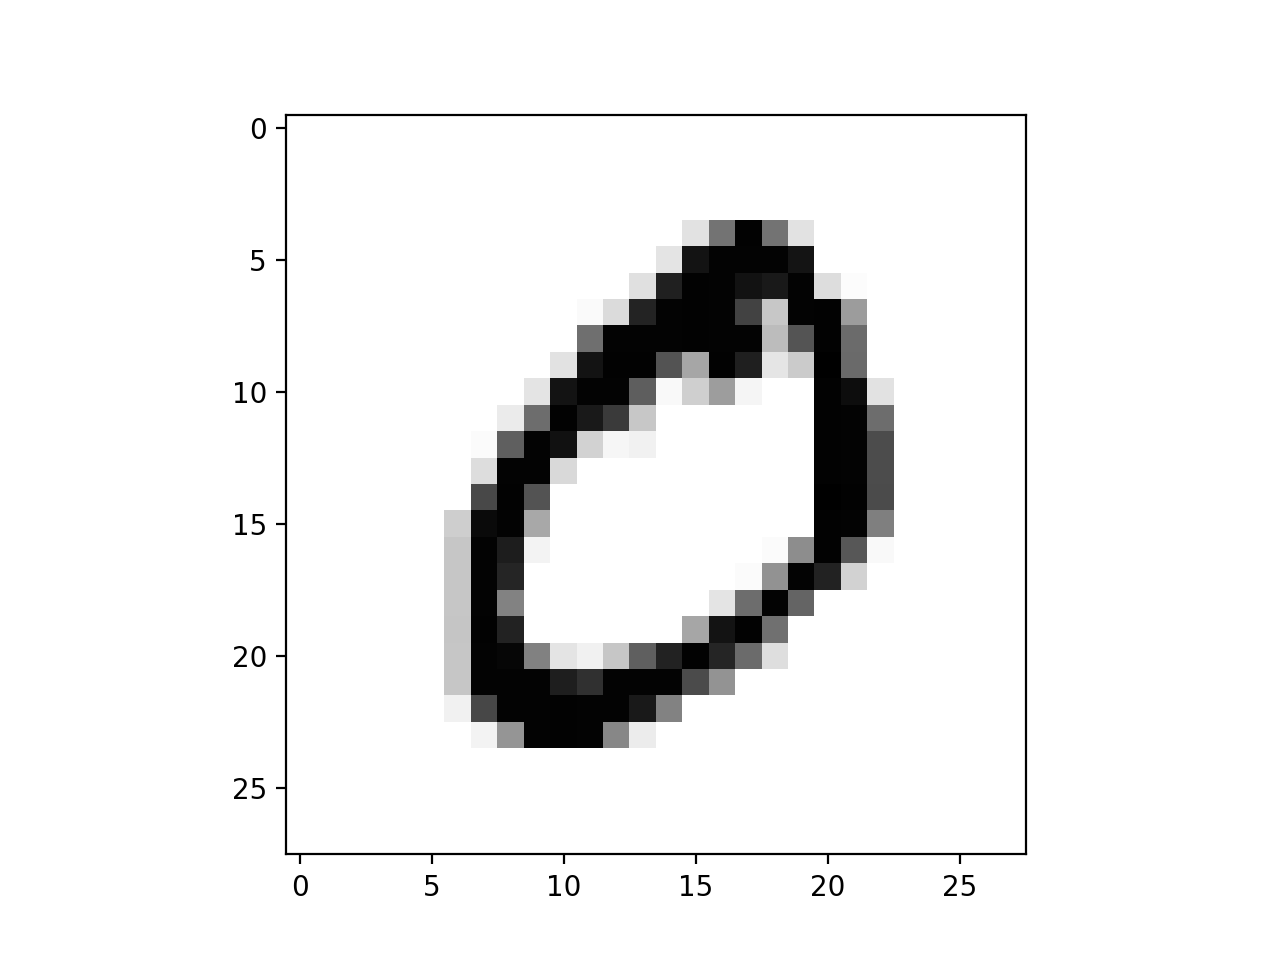

In [7]:
# show an example
print("Shape:", dev_loader.dataset.train_data.shape)
x = dev_loader.dataset.train_data[1]
print("type:", type(x.numpy()))

y = dev_loader.dataset.train_labels[1]
print("Label:",y.numpy())
print("type:", type(y))

plt.imshow(x, cmap=plt.cm.get_cmap('Greys'))
plt.show()

In [8]:
# define the FGN layer class
import math 

class FGN_layer(nn.Module):
    r""" Applies a Finite Gaussian Neuron layer to the incoming data
    
    Args:
    
    Shape:
    
    Attributes:
    
    Examples:
        
        >>> l=FGN_layer(20,30)
    
    """
    def __init__(self, in_features, out_features):
        super(FGN_layer, self).__init__()
        self.in_features = in_features
        self.out_features = out_features
        
        # learnable parameters
        # regular NN weights (transposed at the start, see order of Tensor(dims))
        self.weights = nn.Parameter(torch.Tensor(out_features, in_features), requires_grad= True)
        # centers of FGNs
        self.centers = nn.Parameter(torch.Tensor(out_features, in_features), requires_grad = True)
        # size of FGNs
        self.sigs = nn.Parameter(torch.Tensor(out_features,), requires_grad = True)
        
        # parameter init call
        self.reset_parameters()
    
    # parameter init definition
    def reset_parameters(self):
        # regular NN init
        stdv = 1. / math.sqrt(self.weights.size(1))
        self.weights.data.uniform_(-stdv, stdv)
        
        # size init 
        self.sigs.data.uniform_(-1000.0, 1000.0)
        # centers init
        self.centers.data.uniform_(-1.0, 1.0)
        
    def forward(self, input):
        
        # linear part is the same as normal NNs
        l = nn.functional.linear(input, self.weights, bias=torch.Tensor(self.weights.size()[0]))
        l = torch.tanh(l)
#         print("size of L", l.size())
        
        # gaussian component
        g = -((input-self.centers)**2)
        g = g.sum(dim=1)
        g = g/(self.sigs**2)
        g = torch.exp(g)
        g = g.view(l.size())
#         print(g)
        
#         print("size of G", g.size())
        
        g = torch.exp(-((input-self.centers)**2).sum(dim=1)/(self.sigs**2))
        res = l*g
        # optional, flatten res
        # res = F.tanh(res)
#         print("size of L*G", res.size())

        return res
    

In [9]:
# # dev - is the computation correct?
# inputs = torch.randn(10,5,)
# print("inputs:\n", inputs)
# weights = torch.randn(3,5)
# print("weights:\n", weights)
# centers = torch.randn(3,5)
# print("centers:\n", centers)
# sigs = torch.randn(3,)
# print("sigs:\n", sigs)

# r = inputs-centers
# print(r)
# r = r**2
# print(r)
# r = r.sum(dim=1)
# print(r)
# r = -r/(sigs**2)
# print(r)
# r = torch.exp(r)
# print(r)

# l = nn.functional.linear(inputs, weights, bias=None)
# print("l:\n", l)

# r = r*l
# print(r)

In [10]:
# Define a Finite Gaussian Neural Network

class FGNet(nn.Module):
    def __init__(self):
        super(FGNet, self).__init__()
        self.l1 = FGN_layer(28*28,10)
#         self.l2 = FGN_layer(100,10)

    def forward(self, x):
        # flatten the image first
        x = x.view(1,-1)
        x = self.l1(x)
#         x = self.l2(x)
#         print(x)
        x = F.log_softmax(x, dim=-1)
        
#         final_r = []

#         for sample in x:
#             r = sample.view(-1,28*28)
#             r = self.l1(r)
#             r = self.l2(r)

#             final_r.append(r)

        return x
    
# Initialize the network
model = FGNet().to(device)

In [11]:
# model stats
print(model)
print([p.size() for p in list(model.parameters())])
print("Training?", model.training) 

# check sizes
print("l1")
print(model.l1.weights.size()) 
print(model.l1.centers.size()) 
print(model.l1.sigs.size())
# print("l2")
# print(model.l2.weights.size()) 
# print(model.l2.centers.size()) 
# print(model.l2.sigs.size())

# check weights before training
print("l1")
print(model.l1.weights.view(-1).cpu().detach().numpy()[0:4])
print(model.l1.centers.view(-1).cpu().detach().numpy()[0:4])
print(model.l1.sigs.view(-1).cpu().detach().numpy()[0:4])
# print("l2")
# print(model.l2.weights.view(-1).cpu().detach().numpy()[0:4])
# print(model.l2.centers.view(-1).cpu().detach().numpy()[0:4])
# print(model.l2.sigs.view(-1).cpu().detach().numpy()[0:4])

FGNet(
  (l1): FGN_layer()
)
[torch.Size([10, 784]), torch.Size([10, 784]), torch.Size([10])]
Training? True
l1
torch.Size([10, 784])
torch.Size([10, 784])
torch.Size([10])
l1
[ 0.02864084 -0.02617176 -0.0122432  -0.03396081]
[ 0.63168716 -0.49232388  0.07433295  0.7757282 ]
[ 802.4872  -576.01855 -230.36383  393.23523]


In [12]:
def train(model, device, train_loader, optimizer, epoch):
    
    losses = th.AverageMeter()
    
    # set model to trainable mode
    model.train()
    # load a batch
    for batch_idx, (data, target) in enumerate(train_loader):
        # load batch data, targets to device
        data, target = data.to(device), target.to(device)
        # reset optimizer gradients
        optimizer.zero_grad()
        # compute predictions
        output = model(data)
        # compute loss
        loss = F.nll_loss(output, target)
        # print(loss)
        # update rolling average
        losses.update(loss.item(), data.size(0) )
        # propagate gradients
        loss.backward()
#         print("max grad centers:", torch.max(model.l1.centers.grad) )
#         print("max grad sigs:", torch.max(model.l1.sigs.grad) )

        # apply stored gradients to parameters
        optimizer.step()
        if batch_idx % 10000 == 0:
#             print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
#                 epoch, batch_idx * len(data), len(train_loader.dataset),
#                 100. * batch_idx / len(train_loader), loss.item()))
            print("Loss", losses.avg)

def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, size_average=False ).item() # sum up batch loss
            pred = output.max(1, keepdim=True)[1] # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    


In [13]:
# train the model 

optimizer = optim.SGD(filter(lambda p: p.requires_grad, model.parameters()), lr=0.01, momentum=0.5)

for epoch in range(1, 10):
    train(model, device, dev_loader, optimizer, epoch)
    test(model, device, test_loader)

Loss 2.19525957108

Test set: Average loss: 1.2767, Accuracy: 7243/10000 (72%)

Loss 2.45358681679

Test set: Average loss: 1.3273, Accuracy: 6839/10000 (68%)

Loss 0.907772541046

Test set: Average loss: 1.2489, Accuracy: 7129/10000 (71%)

Loss 0.954468667507

Test set: Average loss: 1.2306, Accuracy: 7323/10000 (73%)

Loss 0.806844472885

Test set: Average loss: 1.2452, Accuracy: 7194/10000 (72%)

Loss 0.832978129387

Test set: Average loss: 1.2186, Accuracy: 7591/10000 (76%)

Loss 0.933446109295

Test set: Average loss: 1.2014, Accuracy: 7653/10000 (77%)

Loss 1.16838371754

Test set: Average loss: 1.2247, Accuracy: 7607/10000 (76%)

Loss 0.808268547058

Test set: Average loss: 1.2257, Accuracy: 7621/10000 (76%)



In [14]:
# check weights after training
print("l1")
print(model.l1.weights.view(-1).cpu().detach().numpy()[0:4])
print(model.l1.centers.view(-1).cpu().detach().numpy()[0:4])
print(model.l1.sigs.view(-1).cpu().detach().numpy()[0:4])
# print("l2")
# print(model.l2.weights.view(-1).cpu().detach().numpy()[0:4])
# print(model.l2.centers.view(-1).cpu().detach().numpy()[0:4])
# print(model.l2.sigs.view(-1).cpu().detach().numpy()[0:4])

l1
[ 0.0610755   0.00626323  0.02019171 -0.0015258 ]
[ 0.63168466 -0.49232388  0.07431546  0.7757216 ]
[ 802.4872  -576.01855 -230.36383  393.23523]


In [15]:
# l1
# [ 0.02864084 -0.02617176 -0.0122432  -0.03396081]
# [ 0.63168716 -0.49232388  0.07433295  0.7757282 ]
# [ 802.4872  -576.01855 -230.36383  393.23523]

In [16]:
# TODO:
# why are centers and sigmas not moving (or moving so little, the grad is NOT zero, but 1e-6 small)?
#     hyper parameters?
# what are good initial parameters for them?